In [1]:
import json
import time
import requests
import warnings
import stanfordnlp

import pandas as pd
import numpy as np

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from langdetect import detect, lang_detect_exception
from bs4 import BeautifulSoup
from multiprocessing import cpu_count

In [2]:
warnings.filterwarnings("ignore")

In [3]:
nlp_uk = stanfordnlp.Pipeline(lang='uk')

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tokenizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tagger.pt', 'pretrain_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_lemmatizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_parser.pt', 'pretrain_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': '

In [4]:
product_url_format = 'https://xl-catalog-api.rozetka.com.ua/v2/goods/get?front-type=xl&category_id={cat_id}&page={page_num}&sort=rank'

In [5]:
comment_url_format = 'https://product-api.rozetka.com.ua/v3/comments/get?front-type=xl&goods={product_id}&page={page_num}&sort=date&limit=10'

## Parse category

In [6]:
tv_cat = 80037

In [7]:
def lang_detect(x):
    try:
        return detect(x)
    except lang_detect_exception.LangDetectException:
        return None


def get_data(cat_id, limit=10):

    product_url = product_url_format.format(cat_id=cat_id, page_num=1)
    resp = requests.get(product_url)
    body = json.loads(resp.text)
    pages_num_p = body['data']['total_pages']

    lst = []
    counter = 0
    for i in range(1, pages_num_p + 1):
        product_url = product_url_format.format(cat_id=cat_id, page_num=i)
        time.sleep(0.5)
        resp = requests.get(product_url)
        body = json.loads(resp.text)
        ids = body['data']['ids']

        for id_ in ids:
            comment_url = comment_url_format.format(product_id=id_, page_num=1)
            time.sleep(0.5)
            resp = requests.get(comment_url)
            body = json.loads(resp.text)
            pages_num_c = body['data']['pages']['count']

            for j in range(1, pages_num_c + 1):
                comment_url = comment_url_format.format(product_id=id_, page_num=j)
                time.sleep(0.5)
                resp = requests.get(comment_url)
                body = json.loads(resp.text)
                data = body['data']['comments']

                for item in data:
                    res = {'user': item['usertitle'], 'mark': item['mark'], 'text': item['text'], 
                           'pros': item['dignity'], 'cons': item['shortcomings']}
                    lang = lang_detect(res['text'].strip())
                    if lang == 'uk' and res not in lst:
                        lst.append(res)
                        counter += 1
                    
                    if counter >= limit:
                        return pd.DataFrame(lst)
                    elif counter % 100 == 0:
                        print(counter)
    return pd.DataFrame(lst)

### Parse

In [8]:
%%time
try:
    df_tv = pd.read_csv('data/reviews_tv.csv')
except FileNotFoundError:
    df_tv = get_data(tv_cat, limit=10000)
    df_tv.to_csv('data/reviews_tv.csv', index=False)

CPU times: user 24.9 ms, sys: 220 µs, total: 25.1 ms
Wall time: 32.4 ms


### Preprocess

In [9]:
import ast

def mark_allign(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return 0
    else:
        return x

In [28]:
df = pd.concat([df_tv])

df = df.loc[(df.mark.notna())]
df['mark'] = df.mark.map(mark_allign)
df = df.loc[df.mark != 0]
df.fillna(" ", inplace=True)
df['target'] = np.where(df.mark < 3, 'neg', np.where(df.mark == 3, 'neu', 'pos'))
# df['text'] = df.apply(lambda row: " ".join([row.text, row.pros, row.cons]).strip(), 1)
df['text'] = df.text.map(lambda x: BeautifulSoup(x).get_text())
df['pros'] = df.pros.map(lambda x: BeautifulSoup(x).get_text())
df['cons'] = df.cons.map(lambda x: BeautifulSoup(x).get_text())
df.drop(['user', 'mark'], 1, inplace=True)
df.reset_index(inplace=True, drop=True)

In [29]:
print(df.shape)
df.head()

(2206, 4)


,text,pros,cons,target
0,В цьому телевізорі все чудово і різнокольорово...,,,pos
1,"Відмінний телевізор. Купив саме те, що хотів. ...","Відмінний телевізор. Купив саме те, що хотів. ...",,pos
2,"Замовив і був задоволений. Простий телевізор, ...",Яскраві кольори,Маленькі ніжки. Раджу купувати одразу кріплення.,pos
3,"Чудовий телевізор, все працює.",Чудова ціна.,Без WiFi,pos
4,Чудовий телевізор,,,pos


In [30]:
target_map = {"neg": 0, "neu": 1, "pos": 2}
df.target = df.target.map(target_map)

In [31]:
df.target.value_counts()

2    1854
0     208
1     144
Name: target, dtype: int64

In [32]:
def tokenize(x):
    if len(x.strip()) == 0:
        return ""
    filter_pos = ('PUNCT', 'ADP', 'SYM', 'CCONJ', 'SCONJ', 'PROPN')
    filter_words = ["і", "та", "або", "й", "то", "б", "але"]
    sentences = nlp_uk(x).sentences
    res = []
    for sent in sentences:
        if '?' in list(sent.words)[-1].text:
            continue
        res.append([token.lemma for token in sent.words if token.upos not in filter_pos])
    try:
        return " ".join(list(filter(lambda x: x not in filter_words, sum(res, [])))).lower()
    except:
        return " "

In [33]:
# df = df[:100]

In [34]:
# try:
#     df = pd.read_csv('data/clean_data.csv')
#     df = df.loc[~df.text.isna()]
# except FileNotFoundError:
text_l = []
pros_l = []
cons_l = []

for text, pros, cons, _ in tqdm(df.values):
    text_l.append(tokenize(text))
    pros_l.append(tokenize(pros))
    cons_l.append(tokenize(cons))

df['clean_text'] = text_l
df['clean_pros'] = pros_l
df['clean_cons'] = cons_l
df['clean_text_all'] = df['clean_pros'] + " " + df['clean_cons'] + " " + df['clean_text']
df = df.loc[~df.text.isna()]

#     df.to_csv('data/clean_data.csv', index=False)

100%|██████████| 2206/2206 [09:00<00:00,  4.08it/s]


In [17]:
df.head()

,text,pros,cons,target,clean_text,clean_pros,clean_cons,clean_text_all
0,В цьому телевізорі все чудово і різнокольорово...,NaN,NaN,2,цей телевізор все чудово різнокольорово чорний...,NaN,NaN,цей телевізор все чудово різнокольорово чорн...
1,"Відмінний телевізор. Купив саме те, що хотів. ...","Відмінний телевізор. Купив саме те, що хотів. ...",NaN,2,відмінний телевізор купити саме те хотіти розе...,відмінний телевізор купити саме те хотіти розе...,NaN,відмінний телевізор купити саме те хотіти розе...
2,"Замовив і був задоволений. Простий телевізор, ...",Яскраві кольори,Маленькі ніжки. Раджу купувати одразу кріплення.,2,замовити бути задоволений простий телевізор на...,яскравий колір,маленький ніжка радити купувати одразу кріплення,яскравий колір маленький ніжка радити купувати...
3,"Чудовий телевізор, все працює.",Чудова ціна.,Без WiFi,2,чудовий телевізор все працювати,чудовий ціна,NaN,чудовий ціна чудовий телевізор все працювати
4,Чудовий телевізор,NaN,NaN,2,чудовий телевізор,NaN,NaN,чудовий телевізор


In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [19]:
neg_text = " ".join(df.loc[df.target == 0].clean_text_all.values)
neu_text = " ".join(df.loc[df.target == 1].clean_text_all.values)
pos_text = " ".join(df.loc[df.target == 2].clean_text_all.values)

In [20]:
wc_pos = WordCloud(background_color='white', width=600, height=300, max_font_size=50, 
                   max_words=40).generate(pos_text)
wc_neu = WordCloud(background_color='white', width=600, height=300, max_font_size=50, 
                   max_words=40).generate(neu_text)
wc_neg = WordCloud(background_color='white', width=600, height=300, max_font_size=50, 
                   max_words=40).generate(neg_text)

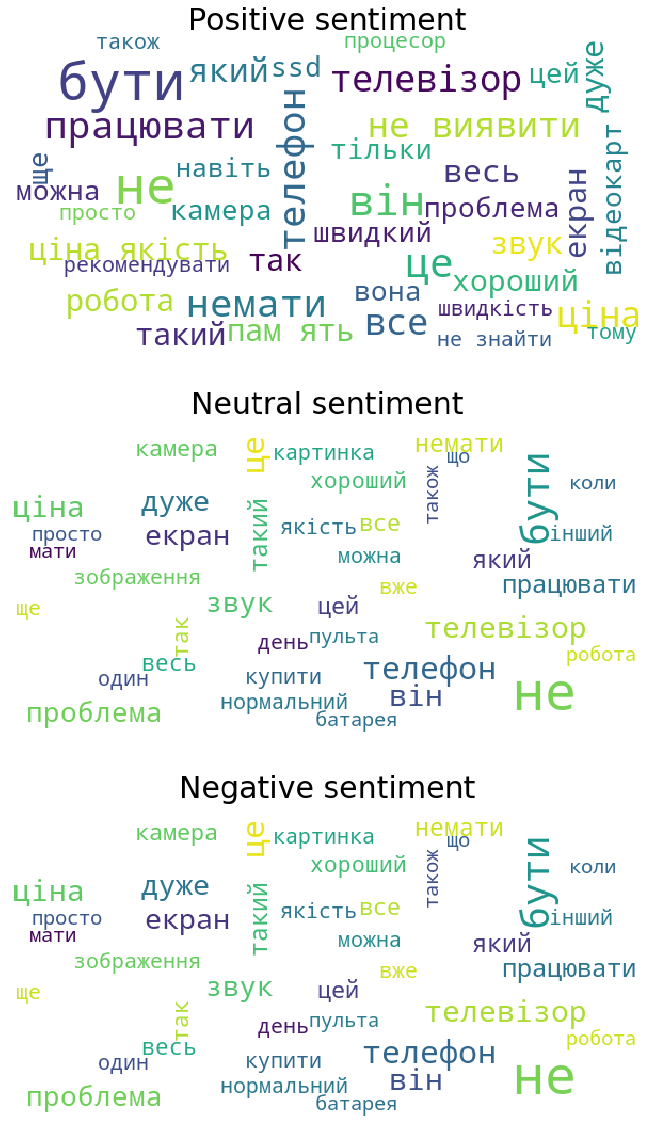

In [21]:
plt.figure(figsize=(12,20))

plt.subplot(3, 1, 1)
plt.imshow(wc_pos)
plt.title("Positive sentiment", fontsize=30)
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(wc_neu)
plt.title("Neutral sentiment", fontsize=30)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(wc_neu)
plt.title("Negative sentiment", fontsize=30)
plt.axis("off")

plt.show()

### Train model

#### NB baseline

In [22]:
RANDOM_STATE = 0

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [37]:
import re

def regex_token(x):
    return " ".join(re.findall(r"\w+", x)).lower()

In [41]:
# df.fillna(" ", inplace=True)

In [42]:
(data, clean_data, target) = ((df["pros"] + " " + df['cons'] + " " + df['text']).map(regex_token),
                              df['clean_text_all'],
                              df['target'])

##### NB, CountVect, removed only punct

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [44]:
c_vect = CountVectorizer()

X_train_vec = c_vect.fit_transform(X_train)
X_test_vec = c_vect.transform(X_test)

In [45]:
%%time

nb_model = GaussianNB()

nb_model.fit(X_train_vec.toarray(), y_train);

CPU times: user 229 ms, sys: 84 ms, total: 313 ms
Wall time: 310 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [46]:
y_pred = nb_model.predict(X_test_vec.toarray())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.10      0.11        42
           1       0.14      0.14      0.14        29
           2       0.85      0.88      0.87       371

    accuracy                           0.76       442
   macro avg       0.38      0.37      0.37       442
weighted avg       0.74      0.76      0.75       442



##### The same with cleaned text

In [47]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [48]:
c_vect = CountVectorizer()

X_train_vec = c_vect.fit_transform(X_train)
X_test_vec = c_vect.transform(X_test)

In [49]:
%%time

nb_model = GaussianNB()

nb_model.fit(X_train_vec.toarray(), y_train);

CPU times: user 161 ms, sys: 44 ms, total: 205 ms
Wall time: 204 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [50]:
y_pred = nb_model.predict(X_test_vec.toarray())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.17      0.17        42
           1       0.10      0.21      0.13        29
           2       0.85      0.78      0.82       371

    accuracy                           0.69       442
   macro avg       0.38      0.39      0.37       442
weighted avg       0.74      0.69      0.71       442



Higher recall on neutrall class, everything else is slightly worse

##### trying tf-idf instead CountVect, standard params, no punct

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [52]:
tfidf_vect = TfidfVectorizer()

X_train_vec = tfidf_vect.fit_transform(X_train)
X_test_vec = tfidf_vect.transform(X_test)

In [53]:
%%time

nb_model = GaussianNB()

nb_model.fit(X_train_vec.toarray(), y_train);

CPU times: user 142 ms, sys: 85 ms, total: 227 ms
Wall time: 226 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [54]:
y_pred = nb_model.predict(X_test_vec.toarray())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.12      0.14        42
           1       0.15      0.14      0.15        29
           2       0.85      0.88      0.86       371

    accuracy                           0.76       442
   macro avg       0.39      0.38      0.38       442
weighted avg       0.74      0.76      0.75       442



##### The same with cleaned text

In [55]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [56]:
tfidf_vect = TfidfVectorizer()

X_train_vec = tfidf_vect.fit_transform(X_train)
X_test_vec = tfidf_vect.transform(X_test)

In [57]:
%%time

nb_model = GaussianNB()

nb_model.fit(X_train_vec.toarray(), y_train);

CPU times: user 99.2 ms, sys: 52 ms, total: 151 ms
Wall time: 148 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [58]:
y_pred = nb_model.predict(X_test_vec.toarray())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.14      0.15        42
           1       0.10      0.21      0.13        29
           2       0.85      0.78      0.82       371

    accuracy                           0.69       442
   macro avg       0.37      0.38      0.37       442
weighted avg       0.74      0.69      0.71       442



Higher recall on neutrall class, everything else is slightly worse

### Trying another alrotithms and approaches

In [59]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [60]:
class_weights = (1 / y_train.value_counts(normalize=True)).to_dict()

##### svc with tf-idf on clean text and weighted classes

In [61]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

In [62]:
def train_eval(clf):
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    print("f1 macro:", f1_score(y_test, y_pred, average='macro'))
    print(clf)

In [63]:
tf_idf = TfidfVectorizer(min_df=5, max_df=0.75)

X_train_vec = tf_idf.fit_transform(X_train)
X_test_vec = tf_idf.transform(X_test)

In [64]:
reg_interval = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100]

for i in reg_interval:
    train_eval(LogisticRegression(C=i, class_weight=class_weights))

f1 macro: 0.5290311895326619
LogisticRegression(C=0.01,
                   class_weight={0: 10.626506024096384, 1: 15.339130434782609,
                                 2: 1.1894807821982467},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
f1 macro: 0.5478885677585099
LogisticRegression(C=0.1,
                   class_weight={0: 10.626506024096384, 1: 15.339130434782609,
                                 2: 1.1894807821982467},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
f1 macro: 0.5737520128824477
LogisticRegression(C=0.2,


In [69]:
model_svc = LinearSVC(C=5, class_weight=class_weights)

model_svc.fit(X_train_vec, y_train);

In [70]:
y_pred = model_svc.predict(X_test_vec)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56        42
           1       0.25      0.31      0.28        29
           2       0.93      0.91      0.92       371

    accuracy                           0.84       442
   macro avg       0.58      0.59      0.59       442
weighted avg       0.85      0.84      0.84       442



In [77]:
model_lr = LogisticRegression(C=5,  class_weight=class_weights)

model_lr.fit(X_train_vec, y_train);

In [78]:
y_pred = model_lr.predict(X_test_vec)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.60      0.59        42
           1       0.24      0.38      0.29        29
           2       0.94      0.89      0.92       371

    accuracy                           0.83       442
   macro avg       0.59      0.62      0.60       442
weighted avg       0.86      0.83      0.84       442



#### trying pipeline

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from scipy.stats import uniform
from sklearn.metrics import make_scorer
from sklearn.decomposition import TruncatedSVD

In [80]:
tf_idf = FeatureUnion([
    ('TfIdf_Unigram', TfidfVectorizer(min_df=5, max_df=0.75, ngram_range=(1, 1), strip_accents='unicode')),
    ('TfIdf_Bigram',  TfidfVectorizer(min_df=2, max_df=0.75, ngram_range=(2, 2), strip_accents='unicode'))
])

In [81]:
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [86]:
# N_COMP = 400

pipeline = Pipeline([
    ("main_union", FeatureUnion([
        ("pipe1", Pipeline([
            ('tf_idf', tf_idf),
        ])),
        ("pipe2", Pipeline([
            ('tf_idf', tf_idf),
            ("SVD", TruncatedSVD())
        ])),
    ])),
#     ('LinearSVC', LinearSVC(class_weight=class_weights))
    ("LogReg", LogisticRegression(max_iter=1000, class_weight=class_weights))
])

distributions = {
#     "LinearSVC__C": [0.5, 1, 5],
    "LogReg__C": [1, 5, 10],
    "LogReg__penalty": ["l2"],
    "main_union__pipe2__SVD__n_components": [300, 400, 500]
}
clf = RandomizedSearchCV(pipeline,
                         distributions,
                         random_state=0,
                         scoring=make_scorer(f1_macro),
                         n_iter=10,
                         cv=5,
                         verbose=5,
                         n_jobs=-1)
search = clf.fit(X_train, y_train)
print(search.best_params_, search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:   18.8s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:   24.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.7s finished


{'main_union__pipe2__SVD__n_components': 300, 'LogReg__penalty': 'l2', 'LogReg__C': 1} 0.5537534707618994


In [87]:
y_pred = search.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58        42
           1       0.24      0.24      0.24        29
           2       0.93      0.93      0.93       371

    accuracy                           0.85       442
   macro avg       0.59      0.58      0.58       442
weighted avg       0.85      0.85      0.85       442



#### out-of-fold LGB training

In [88]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import plot_importance, LGBMClassifier

In [89]:
use_sample_weight = True
N_FOLDS = 4
num_threads = cpu_count()
N_COMP = 400

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [90]:
params = {
    'num_class': 3,
    'num_rounds': 2000,
    'max_depth': -1, #  8
    'learning_rate': 0.01,  #  0.007
    'num_leaves': 31, # was 127
    'verbose': 100,
    'early_stopping_rounds': 300,
    'min_data_in_leaf': 20,
    'lambda_l2': 0.7,
    'feature_fraction': 0.2, #  0.8
    'metric': 'custom',
    'random_state': RANDOM_STATE
}

classifier = LGBMClassifier(**params)

In [91]:
def lgb_fscore(y_true, y_pred):
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1)
    y_pred = y_pred.argmax(axis=0)
    res = f1_score(y_true, y_pred, average='macro')
    return 'macro_f1', res, True

In [92]:
strategy = StratifiedKFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [93]:
train = df.loc[X_train.index]

sample_weight = y_train.map(class_weights).values

test = df.loc[X_test.index]

In [94]:
pred_oof = np.zeros(len(train), dtype=np.float32)
pred_test = np.zeros((len(test), params['num_class'], N_FOLDS), dtype=np.float32)
fold_metrics = np.zeros(N_FOLDS)

In [95]:
for i, (tr_ind, val_ind) in enumerate(strategy.split(X=np.ones(len(train)), y=train['target'])):
    print(f'Fold: {i + 1}\n\tTrain len: {len(tr_ind)}\n\tVal len: {len(val_ind)}')
    pipe = Pipeline([
            ('TFIDF', tf_idf),
            ("SVD", TruncatedSVD(n_components=N_COMP))
        ])
    pipe.fit(train.iloc[tr_ind]['text'])
    
    X = pipe.transform(train.iloc[tr_ind]['text'].copy())
    y = train.iloc[tr_ind]['target'].copy()
    X_val = pipe.transform(train.iloc[val_ind]['text'].copy())
    y_val = train.iloc[val_ind]['target'].copy()
    X_test_ = pipe.transform(test['text'])
    
    # fit model
    print('\tFITTING MODEL...')
    classifier.fit(
        X=X,
        y=y,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose=params['verbose'],
        eval_metric=lgb_fscore,
        sample_weight=sample_weight[tr_ind] if use_sample_weight else None,
    )
    # predict OOF val
    print('\tPREDICT OOF...')
    pred_oof[val_ind] = classifier.predict(X_val, num_threads=num_threads)
    # predict test
    print('\tPREDICTING TEST...')
    pred_test[..., i] = classifier.predict_proba(
        X_test_, num_threads=num_threads)
    fold_metrics[i] = f1_macro(y_val, pred_oof[val_ind])
    print(f'\tFold score: {fold_metrics[i]}')

Fold: 1
	Train len: 1323
	Val len: 441
	FITTING MODEL...
Training until validation scores don't improve for 300 rounds
[100]	valid_0's macro_f1: 0.490339
[200]	valid_0's macro_f1: 0.49291
[300]	valid_0's macro_f1: 0.464555
[400]	valid_0's macro_f1: 0.429982
[500]	valid_0's macro_f1: 0.420167
Early stopping, best iteration is:
[262]	valid_0's macro_f1: 0.503242
	PREDICT OOF...
	PREDICTING TEST...
	Fold score: 0.5032422639704824
Fold: 2
	Train len: 1323
	Val len: 441
	FITTING MODEL...
Training until validation scores don't improve for 300 rounds
[100]	valid_0's macro_f1: 0.448373
[200]	valid_0's macro_f1: 0.442298
[300]	valid_0's macro_f1: 0.435281
Early stopping, best iteration is:
[37]	valid_0's macro_f1: 0.482009
	PREDICT OOF...
	PREDICTING TEST...
	Fold score: 0.4820087603527094
Fold: 3
	Train len: 1323
	Val len: 441
	FITTING MODEL...
Training until validation scores don't improve for 300 rounds
[100]	valid_0's macro_f1: 0.505184
[200]	valid_0's macro_f1: 0.44822
[300]	valid_0's macr

In [96]:
print(f'Total score: ', f1_macro(train['target'], pred_oof))

Total score:  0.4997933657284832


In [97]:
y_pred_raw = pred_test.mean(axis=-1)
y_pred = y_pred_raw.argmax(axis=1).astype(np.int32)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.26      0.35        42
           1       0.00      0.00      0.00        29
           2       0.86      0.97      0.91       371

    accuracy                           0.84       442
   macro avg       0.47      0.41      0.42       442
weighted avg       0.78      0.84      0.80       442



Actually, in practice oof works better and avoids overfitting. But, I didn't use X_test, just to make it possible easy compare results with previous models.

What can also be done:
* add words tonal features from tone-dict-uk.tsv. and concat as sparse matrix
* replace words with tones by tokens like `<positive>` or `<negative>`
* classical features like `word_num`, `text_len`, `has_pros`, `has_cons`, `mean_words_tone` etc. But I'm not sure if it possilbe due to task limitations, as it should be only BoW
* get BoW features w/o pros and cons concatenation

Currently, pipeline with un and bi-grams extended by SVD features shows the best result, not suffering recall for neu class.

### Model explain with eli5

In [98]:
import eli5

In [99]:
eli5.show_weights(model_lr, vec=tf_idf)